# Language abstraction analysis notebook

## Corpus

2+ annotations per item

In [1]:
subdomains = {
    'structures' :  ['bridge', 'castle', 'house', 'city'],
    'drawing' :  ['nuts-bolts','wheels','furniture','dials']
}

domains = list(subdomains.keys())

In [2]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../../stimuli")

import numpy as np
import scipy.stats as stats
import pandas as pd

from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import spacy
nlp = spacy.load("en_core_web_lg")
# sys.path.append("../../stimuli/towers/block_utils/")
# import blockworld_utils as utils

In [3]:
# load dataframe

results_csv_directory = "../../results/csv/"
df_trial = pd.read_csv(os.path.join(results_csv_directory, 'lax_corpus_1k_trial.csv'))
df_trial.loc[:, 'responses'] = df_trial.responses.apply(ast.literal_eval) # needed when reading from csv
df_trial.loc[:, 'whats'] = df_trial.whats.apply(ast.literal_eval) # needed when reading from csv

## Preprocessing

### column name descriptions

```
id
'datatype': 
'iterationName':
'config_name':
    
'condition':
'domain': structures/ drawing
'subdomain': 
'gameID': uuid for participant

'shuffle':
'trialOrder':

'rt': reaction time
'rt_mins': reaction time in minutes

'trial_index': jspsych trial number (not experimental)
'trial_type':
'time_elapsed': 
'complete_dataset': did participant submit 10 responses?
'trial_num': trial number
    
'responses': complete response of what and where messages
'response_lists': same as above, but list of lists
'whats': list of what responses
'wheres': list of where responses
'n_steps': number of steps
'what_messages_lengths': list of lengths of what responses (characters)
'where_messages_lengths': list of lengths of where responses (characters)
'what_char_sum': total characters in what responses
'where_char_sum': total characters in where responses
'char_sum': total characters in responses 
'ppt_hit_8_step_limit': participant was in version of experiment with 8 steps, and hit this limit on at least one trial
``` 

### Metadata    
```
'internal_node_id':
'view_history':
'stimId':
'stimURL':
'stim_group':
'partitionFamily':
'splitNumber':
'stimIDs':
'stimURLS':
'stimGroups':
'numGames':
'experimentType':
'experimentName':
'versionInd':
```

### Add flags for unusual data

In [4]:
# RT less than 5 seconds
df_trial.loc[:, 'short_rt'] = df_trial.rt < 5000

# RT greater than 10 mins
df_trial.loc[:, 'long_rt'] = df_trial.rt > 600000


# Or remove percentile
# np.percentile(df_trial.rt, 99)
# np.percentile(df_trial.rt, 1)

In [5]:
df_trial

,Unnamed: 0,datatype,iterationName,condition,domain,subdomain,config_name,gameID,shuffle,trialOrder,...,wheres,n_steps,what_messages_lengths,where_messages_lengths,what_char_sum,where_char_sum,char_sum,ppt_hit_8_step_limit,short_rt,long_rt
0,0,trial_end,corpus_prolific_test,all,structures,bridge,lax-structures-bridge-corpus-procedural-10,9368-e06ca61c-94a0-44fa-8427-b0f13b13fd4c,NaN,NaN,...,['horizontally on the bottom left hand side '],1,[18],[42],18,42,60,False,False,False
1,1,trial_end,corpus_prolific_test,all,structures,bridge,lax-structures-bridge-corpus-procedural-10,3470-26c59f75-7b3f-446f-a214-583ee92a938e,NaN,NaN,...,"['adjacent to each other', 'around the red blo...",3,"[15, 20, 15]","[22, 52, 100]",50,174,224,False,False,False
2,2,trial_end,corpus_prolific_test,all,structures,bridge,lax-structures-bridge-corpus-procedural-10,3470-26c59f75-7b3f-446f-a214-583ee92a938e,NaN,NaN,...,"['forming four straight lines, 2 in the middle...",2,"[14, 15]","[67, 130]",29,197,226,False,False,False
3,3,trial_end,corpus_prolific_test,all,structures,bridge,lax-structures-bridge-corpus-procedural-10,3470-26c59f75-7b3f-446f-a214-583ee92a938e,NaN,NaN,...,"['in five two block wide lines, getting longer...",2,"[14, 15]","[116, 80]",29,196,225,False,False,False
4,4,trial_end,corpus_prolific_test,all,structures,bridge,lax-structures-bridge-corpus-procedural-10,3470-26c59f75-7b3f-446f-a214-583ee92a938e,NaN,NaN,...,"['in 3 lines, the middle one being 2 blocks w...",2,"[14, 15]","[47, 19]",29,66,95,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6552,6552,trial_end,corpus_prolific_test_3,all,drawing,dials,lax-drawing-dials-corpus-procedural-10,6312-77e51ec3-21ac-46e5-a70b-1aedddc299d7,NaN,NaN,...,"['in the centre of the square draw a circle', ...",7,"[8, 34, 53, 24, 54, 27, 69]","[41, 61, 22, 102, 59, 49, 6]",269,340,609,False,False,False
6553,6553,trial_end,corpus_prolific_test_3,all,drawing,dials,lax-drawing-dials-corpus-procedural-10,6312-77e51ec3-21ac-46e5-a70b-1aedddc299d7,NaN,NaN,...,"['in the square draw a circle', 'AT 12oclock o...",2,"[19, 41]","[27, 20]",60,47,107,False,False,False
6554,6554,trial_end,corpus_prolific_test_3,all,drawing,dials,lax-drawing-dials-corpus-procedural-10,6312-77e51ec3-21ac-46e5-a70b-1aedddc299d7,NaN,NaN,...,['from the top of the rectangle draw a vertica...,2,"[16, 23]","[59, 36]",39,95,134,False,False,False
6555,6555,trial_end,corpus_prolific_test_3,all,drawing,dials,lax-drawing-dials-corpus-procedural-10,6312-77e51ec3-21ac-46e5-a70b-1aedddc299d7,NaN,NaN,...,"['draw a smaller line below the T line', 'Draw...",6,"[13, 39, 46, 51, 60, 34]","[36, 51, 38, 19, 54, 15]",243,213,456,False,False,False


### Linguistic preprocessing

In [6]:
df_trial['processed_whats'] = [list(nlp.pipe(text)) for text in df_trial['whats']]
df_trial['lemmatized_whats'] = [[[str(w.lemma_) for w in sentence] for sentence in text] for text in df_trial['processed_whats']]

## Analysis of programs

- gallery: longest / average-length / shortest programs in each domain
- length: 
- diversity domain-specificity
- program token-level distinctiveness
- in: domain, subdomain, library_0 vs. library_compressive


In [7]:
# read gadgets metadata (does not include dreamcoder programs)
df_drawing = pd.DataFrame()

for drawing_subdomain in subdomains['drawing']:
    df_sub = pd.read_csv('https://lax-drawing-{}-all.s3.amazonaws.com/manifest.csv'.format(drawing_subdomain))
    df_drawing = df_drawing.append(df_sub, ignore_index=True)
    

In [8]:
# read gadgets metadata (includes dreamcoder programs)
df_structures = pd.DataFrame()

for structure_subdomain in subdomains['structures']:
    df_sub = pd.read_csv('https://lax-structures-{}-all.s3.amazonaws.com/df_{}.csv'.format(structure_subdomain,
                                                                                           structure_subdomain))
    df_structures = df_structures.append(df_sub, ignore_index=True)

In [9]:
# df_structures['dreamcoder_program'].apply(lambda program: program.count('h') + program.count('t'))

## Analysis of language

- Visualize: longest / average-length / shortest word counts in each domain
- token-level diversity: across domains, across subdomains within domain, across stims within subdomain, across participants
- token-level distinctiveness (PMI, tf-idf): across domains, across subdomains within domain, across stims within subdomain, across participants
- same as above, but now on "semantic" representations: gLoVe embeddings / BERT / & co. from huggingface / Spacy has all of these i think-> show a tsne


### Word counts

token-based length: across domains, across subdomains within domain, across stims within subdomain, across participants

<AxesSubplot:xlabel='what_char_sum', ylabel='Count'>

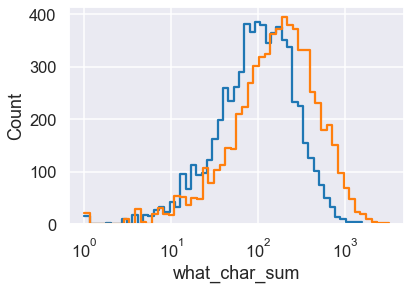

In [10]:
sns.histplot(data = df_trial, x="what_char_sum", log_scale=True, fill=False, element="step")
sns.histplot(data = df_trial, x="where_char_sum", log_scale=True, fill=False, element="step")

<AxesSubplot:xlabel='what_char_sum', ylabel='Density'>

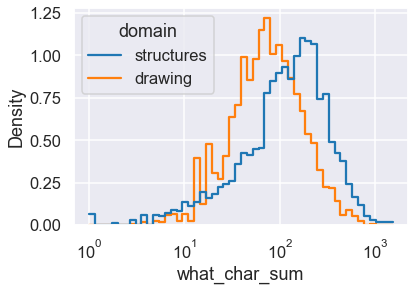

In [11]:
sns.histplot(data = df_trial, x="what_char_sum", hue='domain', stat="density", common_norm=False, log_scale=True, fill=False, element="step")

TODO: order different stimuli by 'easiest' and 'hardest' (i.e. 'least words' on average, 'most words' on average)

### Most common words

gallery: visualizing most frequent words, moderately frequent words, least frequent words

In [12]:
from collections import Counter

In [13]:
word_counts = Counter([d for sublist in df_trial['lemmatized_whats'] 
                      for item in sublist
                      for d in item])

In [14]:
word_counts.most_common(30)

[('blue', 17369),
 ('block', 14645),
 ('red', 11468),
 ('2', 6723),
 ('two', 6593),
 ('a', 6161),
 ('rectangle', 5482),
 ('of', 4989),
 ('the', 4674),
 ('brick', 4472),
 (',', 4456),
 ('4', 4303),
 ('horizontal', 3334),
 ('small', 2944),
 ('vertical', 2717),
 ('1', 2535),
 ('circle', 2349),
 ('one', 2348),
 ('line', 2094),
 ('and', 2009),
 ('square', 1942),
 ('four', 1854),
 ('on', 1749),
 ('6', 1580),
 ('3', 1557),
 ('to', 1350),
 ('in', 1341),
 ('with', 1340),
 ('side', 1283),
 ('8', 1267)]

In [15]:
counters = {}
for domain_name, df in df_trial.groupby('domain') :
    flattened_words = [d for sublist in df['lemmatized_whats'] 
                       for item in sublist
                       for d in item]
    counters[domain_name] = Counter(flattened_words)

In [16]:
counters['structures'].most_common(30)

[('blue', 17369),
 ('block', 14641),
 ('red', 11468),
 ('2', 5925),
 ('two', 5122),
 ('brick', 4472),
 ('4', 4006),
 ('of', 3696),
 (',', 3487),
 ('horizontal', 2659),
 ('a', 2559),
 ('the', 2326),
 ('rectangle', 2228),
 ('1', 2196),
 ('vertical', 2037),
 ('one', 1888),
 ('four', 1594),
 ('on', 1555),
 ('and', 1550),
 ('3', 1395),
 ('6', 1386),
 ('row', 1258),
 ('8', 1139),
 ('horizontally', 1127),
 ('to', 1040),
 ('side', 1007),
 ('in', 946),
 ('vertically', 881),
 ('top', 872),
 ('repeat', 849)]

In [17]:
counters['drawing'].most_common(30)

[('a', 3602),
 ('rectangle', 3254),
 ('small', 2875),
 ('circle', 2349),
 ('the', 2348),
 ('line', 1919),
 ('square', 1742),
 ('two', 1471),
 ('of', 1293),
 (',', 969),
 ('2', 798),
 ('vertical', 680),
 ('horizontal', 675),
 ('large', 638),
 ('with', 629),
 ('hexagon', 536),
 ('one', 460),
 ('and', 459),
 ('long', 402),
 ('draw', 395),
 ('in', 395),
 ('height', 392),
 ('as', 392),
 ('.', 387),
 ('wheel', 383),
 ('about', 353),
 ('1', 339),
 ('be', 311),
 ('to', 310),
 ('length', 301)]

In [18]:
df_trial['lemmatized_whats']

0                               [[the, top, blue, brick]]
1       [[both, red, block], [the, four, blue, block],...
2                 [[the, red, block], [the, blue, block]]
3                 [[the, red, block], [the, blue, block]]
4                 [[the, red, block], [the, blue, block]]
                              ...                        
6552    [[a, square], [in, the, circle, draw, an, inne...
6553    [[draw, a, small, square], [in, the, circle, d...
6554    [[draw, a, rectangle], [ , make, the, line, in...
6555    [[draw, a, t, with], [draw, a, square, at, the...
6556     [[draw, a, t, line], [draw, two, small, square]]
Name: lemmatized_whats, Length: 6557, dtype: object

In [19]:
[w.lemma_ for w in df_trial['processed_whats'][105][0]]

['the',
 'same',
 'column',
 'as',
 'before',
 'but',
 'with',
 'a',
 'double',
 'depth',
 'bridge',
 'of',
 'blue',
 'rectangle']

In [20]:
d1 = nlp(df_trial['whats'][0][0])
d2 = nlp(df_trial['whats'][1][0])
d3 = nlp('The dog chased the horse')

In [21]:
d2

both red blocks

In [22]:
for word in d2 :
    print('word:', word.text)
    print('lemma:', word.lemma_)
    print('dependency', word.dep_)
    print('part of speech', word.pos_)
    print('-----')

word: both
lemma: both
dependency preconj
part of speech CCONJ
-----
word: red
lemma: red
dependency amod
part of speech ADJ
-----
word: blocks
lemma: block
dependency ROOT
part of speech NOUN
-----


In [23]:
d1.similarity(d2)

0.7749149666726374

# Embeddings

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [25]:
EMBEDDING_CONTEXTUAL = "contextual"
EMBEDDING_STATIC = "static"

CONTEXTUAL_DEFAULT_MODEL = "distilbert-base-uncased"

spacy_nlp = spacy.load("en_core_web_lg")

In [26]:
def untokenized_strings_to_pretrained_embeddings(strings_tensor, embedding_type):
    """
    Tokenizes and embeds a set of strings.
    :param:
        strings_tensor: n_strings array of untokenized strings.
        embedding_type: ["dummy", "contextual", "static"] - default choices around tokenizers.
        embedding_size : [embedding_size_sm, embedding_size_lg] - whether to use a default smaller size of embeddings.
    :ret:
        tokens_tensor : unpadded list of n_strings x n_tokens
        embedding_tensor: n_strings x max_len x embedding_dim : - embeddings for tokenized strings.
        attention_mask: B x max_len - 1-hot mask indicating padding.
    """
    if embedding_type == EMBEDDING_STATIC:
        # Tokenize using off the shelf tokenizer.
        def replace_unk_like(vector, off_set=1.0):
            # Don't allow spacy to use 0-vector as UNK.
            if vector.sum() == 0:
                return vector - off_set
            else:
                return vector

#         spacy_tokens_tensor = [
#             [token for token in spacy_nlp(sentence)] for sentence in strings_tensor
#         ]
        spacy_tokens_tensor = [
            [spacy_nlp(sentence)[0]] for sentence in strings_tensor
        ]
        tokens_tensor = [
            [token.text for token in sentence] for sentence in spacy_tokens_tensor
        ]
        unpadded_token_embeddings = [
            torch.tensor([replace_unk_like(token.vector) for token in sentence])
            for sentence in spacy_tokens_tensor
        ]

    elif embedding_type == EMBEDDING_CONTEXTUAL:
        from transformers import AutoTokenizer, AutoModel, pipeline

        model = AutoModel.from_pretrained(CONTEXTUAL_DEFAULT_MODEL)
        tokenizer = AutoTokenizer.from_pretrained(CONTEXTUAL_DEFAULT_MODEL)
        nlp = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

        # Redundant: we get the tokens again so we can have their string values
        tokens_tensor = [
            tokenizer.convert_ids_to_tokens(token_ids[1:-1])
            for token_ids in tokenizer(strings_tensor)["input_ids"]
        ]

        # TODO (@catwong): replace pipeline if this is too slow to do redundantly
        unpadded_token_embeddings = [
            torch.tensor(sentence_embeddings).squeeze()[1:-1]
            for sentence_embeddings in nlp(strings_tensor)
        ]

    else:
        raise ValueError(f"Unknown embedding type: {embedding_type}")

    padded_token_embeddings = pad_sequence(unpadded_token_embeddings, batch_first=True)
    attention_mask = torch.sum(padded_token_embeddings, dim=-1) == 0

    return tokens_tensor, padded_token_embeddings, attention_mask

In [27]:
strings_tensor = sorted(list(counters['drawing'].keys()))

In [28]:
tokens_tensor, padded_token_embeddings, attention_mask = untokenized_strings_to_pretrained_embeddings(strings_tensor, embedding_type=EMBEDDING_STATIC)

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_23882/674511152.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/torch/csrc/utils/tensor_new.cpp:201.)
  torch.tensor([replace_unk_like(token.vector) for token in sentence])


In [29]:
padded_token_embeddings.shape

torch.Size([1163, 1, 300])

In [30]:
[tt for tt in tokens_tensor if len(tt) > 1]

[]

In [31]:
tokens_tensor[1000]

['stretch']

# PCA

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=50)
X = pca.fit_transform(padded_token_embeddings.squeeze())
sum(pca.explained_variance_ratio_)

0.840386901712689

# TSNE 2D

In [34]:
from sklearn.manifold import TSNE

In [35]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random',
                  perplexity=10 # Changing perplexity significantly affects qualitative results
                 ).fit_transform(X)
X_embedded.shape

(1163, 2)

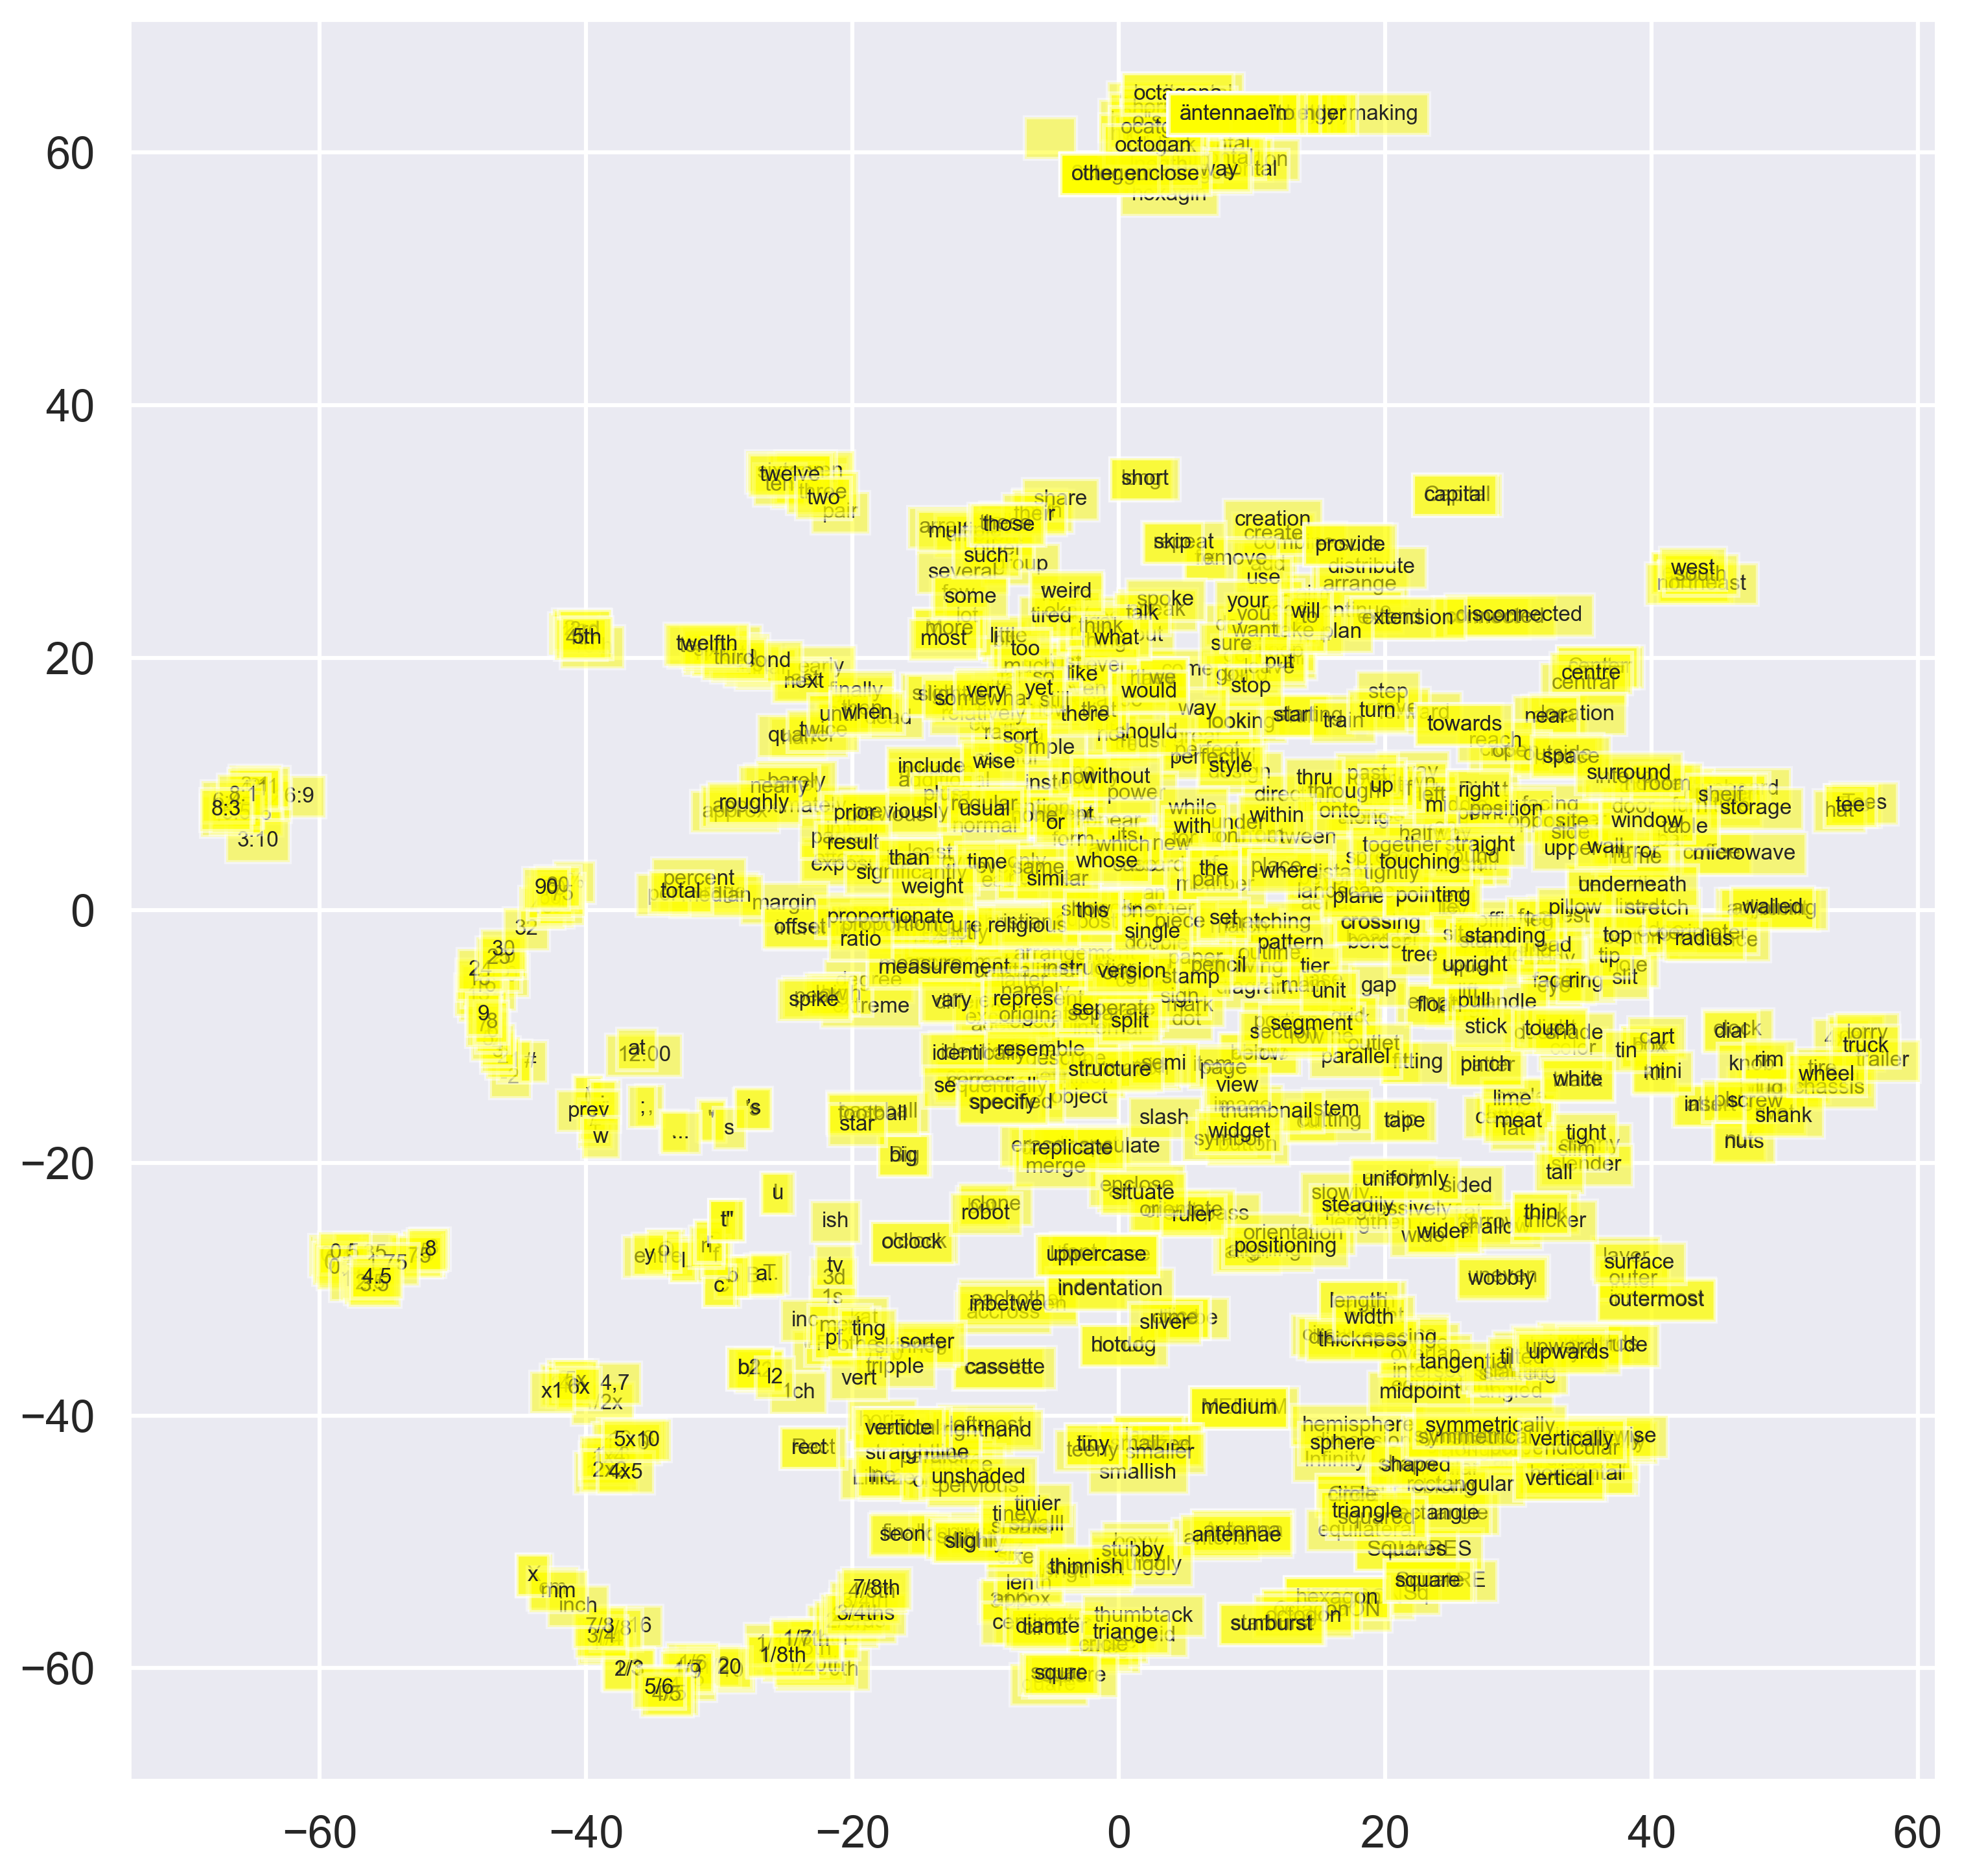

In [36]:
plt.figure(figsize=(12, 12), dpi=300)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], alpha=0)
for i, label in enumerate(strings_tensor):
    plt.text(x=X_embedded[i,0], y=X_embedded[i,1], s=label, fontsize=8, 
             bbox=dict(facecolor='yellow',alpha=0.5))

In [37]:
import plotly.express as px
import plotly.graph_objects as go

In [42]:
fig = px.scatter(
    x=X_embedded[:,0], 
    y=X_embedded[:,1], 
    text=strings_tensor,
    width=1000, 
    height=1000)
fig.update_traces(textposition='top center')
fig.show()

# TSNE 3D

In [39]:
X_embedded_3d = TSNE(n_components=3, learning_rate='auto',
                  init='random').fit_transform(X)
X_embedded_3d.shape

(1163, 3)

In [40]:
trace = go.Scatter3d(
            x=X_embedded_3d[:,0],
            y=X_embedded_3d[:,1],
            z=X_embedded_3d[:,2],
            mode="markers",
            marker=dict(size=0),
            hoverinfo="skip")
    
annos = []
for i, label in enumerate(strings_tensor):
    anno = dict(
            x=X_embedded_3d[i,0],
            y=X_embedded_3d[i,1],
            z=X_embedded_3d[i,2],
                text=label,
                showarrow=False,
                arrowhead=0,
                font=dict(color="black", size=10),
                ax=0,
                ay=-20,
                bgcolor="yellow",
                opacity=0.85)

    annos.append(anno)
        
fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(scene=dict(annotations=annos))